# Journey through Springfield.

This time we have to help the FOX TV company in processing their content. As we know, the Simsons series has been on television for more than 25 years, and during this time a lot of video material has accumulated. Characters have changed along with changing graphic technologies and Homer 2018 is not very similar to Homer 1989. Our task will be to learn how to classify the characters living in Springfield. I think it makes no sense to present each of them separately.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Install dependencies

In [ ]:
!pip install torchvision

In [ ]:
!pip3 install wheel

In [ ]:
# install the correct version of torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# we need pillow version 5.3.0
# uninstall the old version and install the new one
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0
# this should be version 5.3.0. if this is not the case, restart this Jupiter notebook:
# Menu > Runtime > Restart Runtime

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [ ]:
#!ls -l /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
#!ls -1

In [ ]:
# start Jupiter notebook on the Kaggle platform
from pathlib import Path
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset/')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991
train_val_labels = [path.parent.name for path in train_val_files]

20933
991


In [ ]:
#!ls train
#!ls testset

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Aug  8 03:40:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In our test, there will be 990 cards for which we will need to predict the class.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# not everything is good in sklearn so that it is convenient to display pictures in colab
# we will ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# different modes
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to 224x224 px
RESCALE_SIZE = 224
# work on the video card
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Below we use a wrapper over the dataset for convenient work. We need to understand what is going on with LabelEncoder and with torch.Transformation.

ToTensor converts a PIL Image with parameters in the [0, 255] range (as all pixels) into a FloatTensor of size (C x H x W) [0,1] , then scales:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br> constants - means and variances across channels based on ImageNet


It's also worth noting that we override the __getitem__ method to make it easier to work with this data structure.
  It also uses LabelEncoder to convert string class labels to id and vice versa. The description of the dataset indicates that the pictures are of different sizes, since they were taken directly from the video, so we should bring them to the same size (this is done by the _prepare_sample method)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Dataset with pictures, which simultaneously loads them from folders
    performs scaling and transformation into torch tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # list of files to upload
        self.files = sorted(files)
        # operating mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # to convert images to PyTorch tensors and normalize input
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        data_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomHorizontalFlip(p=0.5)
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
          x = data_transforms(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

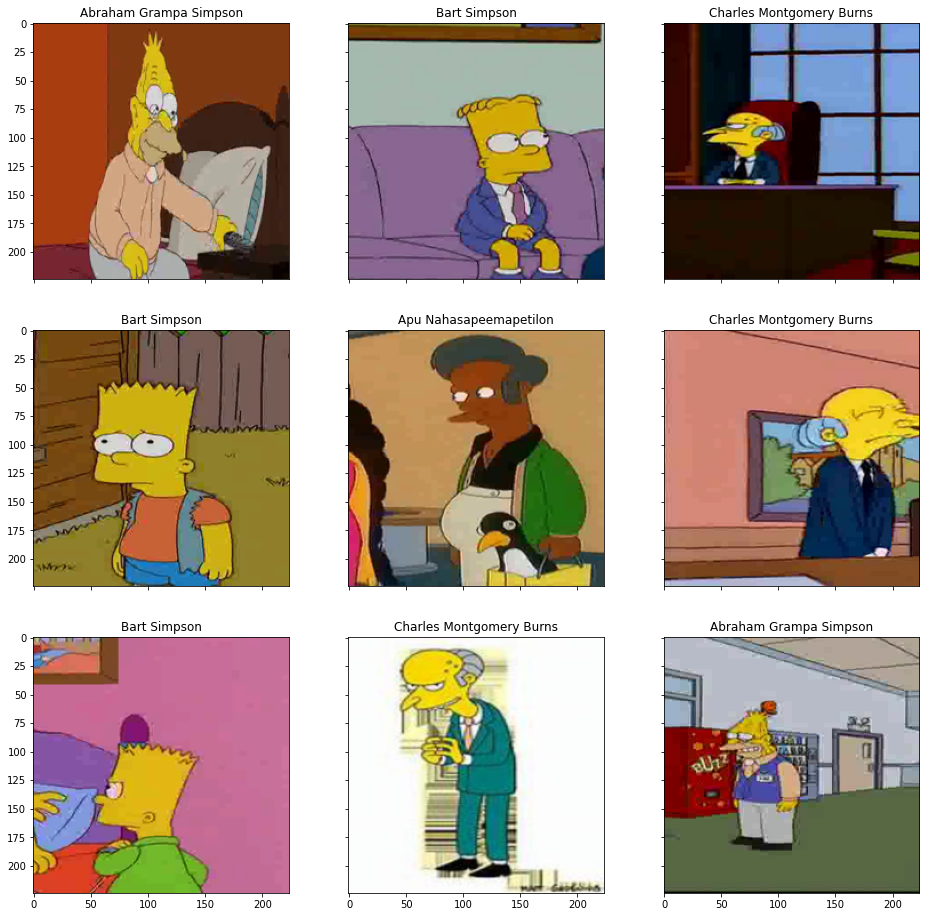

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
#Trying the VGG19_bn NN

In [ ]:
import torchvision.models as models

n_classes = len(np.unique(train_val_labels))

vgg19_bn = models.vgg19_bn(pretrained=True)

layers_to_unfreeze = 16

# Turn off gradient counting for layers we won't train
for param in vgg19_bn.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 25088

vgg19_bn.classifier = nn.Linear(num_features, n_classes)

vgg19_bn = vgg19_bn.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(vgg19_bn)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

we will classify :42
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [ ]:
# display the parameters of the neural network
params_to_update = vgg19_bn.parameters()
print("Params to learn:")

params_to_update = []
for name,param in vgg19_bn.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 features.37.weight
	 features.37.bias
	 features.40.weight
	 features.40.bias
	 features.41.weight
	 features.41.bias
	 features.43.weight
	 features.43.bias
	 features.44.weight
	 features.44.bias
	 features.46.weight
	 features.46.bias
	 features.47.weight
	 features.47.bias
	 features.49.weight
	 features.49.bias
	 features.50.weight
	 features.50.bias
	 classifier.weight
	 classifier.bias


In [ ]:
history = train(train_dataset, val_dataset, model=vgg19_bn, epochs=30, batch_size=256)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.1231212083800095


epoch:   3%|▎         | 1/30 [05:47<2:48:11, 347.99s/it]


Epoch 001 train_loss: 1.1231     val_loss 0.5703 train_acc 0.7213 val_acc 0.8500
loss 3.1708410256865283


epoch:   7%|▋         | 2/30 [09:36<2:09:35, 277.70s/it]


Epoch 002 train_loss: 3.1708     val_loss 3.1333 train_acc 0.1305 val_acc 0.1074
loss 3.1212999867788507


epoch:  10%|█         | 3/30 [13:24<1:54:46, 255.06s/it]


Epoch 003 train_loss: 3.1213     val_loss 3.1165 train_acc 0.1073 val_acc 0.1074
loss 3.0631052997888473


epoch:  13%|█▎        | 4/30 [17:14<1:46:15, 245.21s/it]


Epoch 004 train_loss: 3.0631     val_loss 2.9948 train_acc 0.1168 val_acc 0.1402
loss 2.8620252844497456


epoch:  17%|█▋        | 5/30 [21:07<1:40:16, 240.66s/it]


Epoch 005 train_loss: 2.8620     val_loss 2.6905 train_acc 0.1701 val_acc 0.1962
loss 2.575627152908683


epoch:  20%|██        | 6/30 [24:57<1:34:53, 237.23s/it]


Epoch 006 train_loss: 2.5756     val_loss 2.8030 train_acc 0.2493 val_acc 0.1861
loss 2.3414023878528964


epoch:  23%|██▎       | 7/30 [28:47<1:29:58, 234.73s/it]


Epoch 007 train_loss: 2.3414     val_loss 2.2356 train_acc 0.3119 val_acc 0.3605
loss 2.0791110983851064


epoch:  27%|██▋       | 8/30 [32:44<1:26:21, 235.53s/it]


Epoch 008 train_loss: 2.0791     val_loss 1.9062 train_acc 0.3998 val_acc 0.4595
loss 1.8203181704409344


epoch:  30%|███       | 9/30 [36:36<1:22:03, 234.47s/it]


Epoch 009 train_loss: 1.8203     val_loss 1.6792 train_acc 0.4900 val_acc 0.5481
loss 1.4869906076147827


epoch:  33%|███▎      | 10/30 [40:29<1:17:56, 233.81s/it]


Epoch 010 train_loss: 1.4870     val_loss 1.3545 train_acc 0.5961 val_acc 0.6355
loss 1.1864498220011568


epoch:  37%|███▋      | 11/30 [44:21<1:13:51, 233.26s/it]


Epoch 011 train_loss: 1.1864     val_loss 1.0756 train_acc 0.6805 val_acc 0.7117
loss 0.9085568456530108


epoch:  40%|████      | 12/30 [48:13<1:09:54, 233.02s/it]


Epoch 012 train_loss: 0.9086     val_loss 0.9691 train_acc 0.7555 val_acc 0.7457
loss 0.7067665237421078


epoch:  43%|████▎     | 13/30 [52:03<1:05:46, 232.13s/it]


Epoch 013 train_loss: 0.7068     val_loss 0.7302 train_acc 0.8074 val_acc 0.8177
loss 0.5580426474324958


epoch:  47%|████▋     | 14/30 [55:53<1:01:40, 231.29s/it]


Epoch 014 train_loss: 0.5580     val_loss 0.6325 train_acc 0.8499 val_acc 0.8439
loss 0.44747997610513873


epoch:  50%|█████     | 15/30 [59:41<57:37, 230.47s/it]  


Epoch 015 train_loss: 0.4475     val_loss 0.5505 train_acc 0.8790 val_acc 0.8619
loss 0.3783034610515932


epoch:  53%|█████▎    | 16/30 [1:03:31<53:44, 230.34s/it]


Epoch 016 train_loss: 0.3783     val_loss 0.5599 train_acc 0.8948 val_acc 0.8678
loss 0.32328225801902877


epoch:  57%|█████▋    | 17/30 [1:07:22<49:55, 230.39s/it]


Epoch 017 train_loss: 0.3233     val_loss 0.5113 train_acc 0.9117 val_acc 0.8703
loss 0.27927255899300657


epoch:  60%|██████    | 18/30 [1:11:12<46:03, 230.28s/it]


Epoch 018 train_loss: 0.2793     val_loss 0.4729 train_acc 0.9231 val_acc 0.8859
loss 0.2249169354871911


epoch:  63%|██████▎   | 19/30 [1:15:00<42:05, 229.58s/it]


Epoch 019 train_loss: 0.2249     val_loss 0.4802 train_acc 0.9370 val_acc 0.8951
loss 0.20823670650061563


epoch:  67%|██████▋   | 20/30 [1:18:51<38:19, 229.98s/it]


Epoch 020 train_loss: 0.2082     val_loss 0.4276 train_acc 0.9431 val_acc 0.9031
loss 0.15437940862408275


epoch:  70%|███████   | 21/30 [1:22:42<34:32, 230.33s/it]


Epoch 021 train_loss: 0.1544     val_loss 0.4409 train_acc 0.9572 val_acc 0.9094
loss 0.15767703929997773


epoch:  73%|███████▎  | 22/30 [1:26:33<30:45, 230.65s/it]


Epoch 022 train_loss: 0.1577     val_loss 0.5199 train_acc 0.9565 val_acc 0.9020
loss 0.12567814736865465


epoch:  77%|███████▋  | 23/30 [1:30:27<27:01, 231.57s/it]


Epoch 023 train_loss: 0.1257     val_loss 0.4209 train_acc 0.9658 val_acc 0.9094
loss 0.11622194854501205


epoch:  80%|████████  | 24/30 [1:34:21<23:14, 232.41s/it]


Epoch 024 train_loss: 0.1162     val_loss 0.4181 train_acc 0.9675 val_acc 0.9087
loss 0.10098093049591822


epoch:  83%|████████▎ | 25/30 [1:38:15<19:24, 232.93s/it]


Epoch 025 train_loss: 0.1010     val_loss 0.4303 train_acc 0.9717 val_acc 0.9133
loss 0.08756941722989409


epoch:  87%|████████▋ | 26/30 [1:42:10<15:34, 233.55s/it]


Epoch 026 train_loss: 0.0876     val_loss 0.4854 train_acc 0.9743 val_acc 0.9014
loss 0.07418950876010225


epoch:  90%|█████████ | 27/30 [1:46:05<11:41, 233.90s/it]


Epoch 027 train_loss: 0.0742     val_loss 0.5255 train_acc 0.9785 val_acc 0.9062
loss 0.07267899387886557


epoch:  93%|█████████▎| 28/30 [1:49:55<07:45, 232.75s/it]


Epoch 028 train_loss: 0.0727     val_loss 0.5252 train_acc 0.9786 val_acc 0.9173
loss 0.06866153378873215


epoch:  97%|█████████▋| 29/30 [1:53:44<03:51, 231.51s/it]


Epoch 029 train_loss: 0.0687     val_loss 0.4716 train_acc 0.9810 val_acc 0.9150
loss 0.06962044476023338


epoch: 100%|██████████| 30/30 [1:57:32<00:00, 235.09s/it]


Epoch 030 train_loss: 0.0696     val_loss 0.4605 train_acc 0.9794 val_acc 0.9165


Display the learning curves

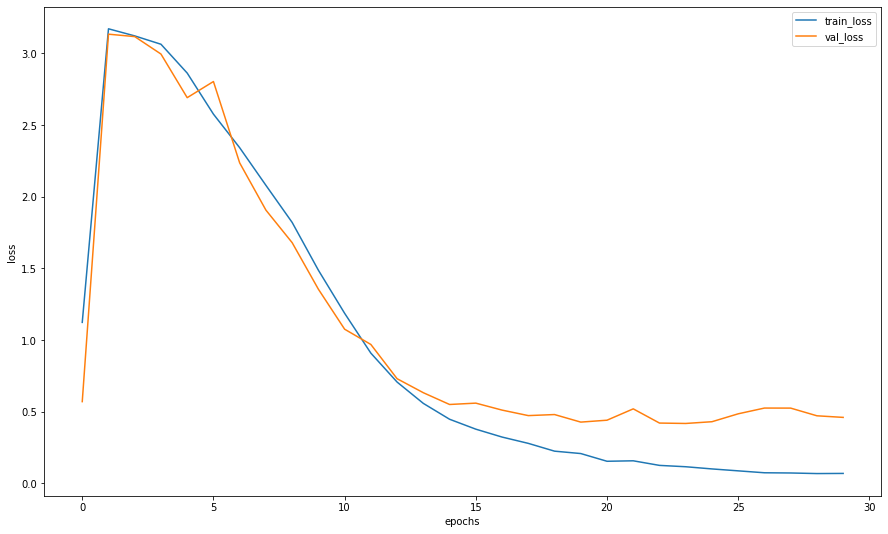

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### So now what to do with all this?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

It would be nice to understand how to make a submit.
We have a neural network and its eval methods, which allow us to put the network into prediction mode. It should be understood that our model has softmax on the last layer, which allows you to get a vector of probabilities that an object belongs to a particular class. Let's use this.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Prediction, for one picture"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(vgg19_bn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(vgg19_bn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Note that the metric to be optimized in the task is f1-score. Let's calculate the target metric on the validation set.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9

Let's make a cool visualization to see how confident the neural network is in its answers. We will use the code below to debug the correctness of the output.

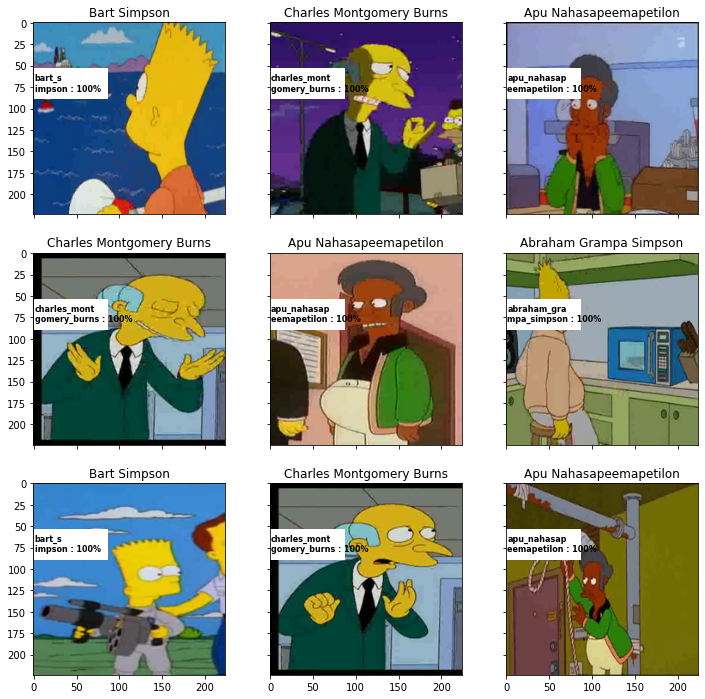

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(vgg19_bn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(vgg19_bn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("../input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('vgg19_bn_unfr_16_epoch_30.csv', index=False)